In [16]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, FloatSlider
import ipywidgets as widgets
from plotly.subplots import make_subplots
import plotly.graph_objects as go

## Import Data

In [2]:
data=pd.read_csv("/Users/jchen056/Data/hourly_data_aggregated.csv")
data.drop(columns=['Unnamed: 0'],axis=0,inplace=True)
data.head()

,station_complex,borough,date,hour,month,weekdays,num_lines,ridership,TMAX,TMIN,PRCP,avg_T
0,1 Av (L),M,2022-02-01,0,2,1,1,124,36,23,0.0,29.5
1,1 Av (L),M,2022-02-01,1,2,1,1,28,36,23,0.0,29.5
2,1 Av (L),M,2022-02-01,2,2,1,1,38,36,23,0.0,29.5
3,1 Av (L),M,2022-02-01,3,2,1,1,14,36,23,0.0,29.5
4,1 Av (L),M,2022-02-01,4,2,1,1,26,36,23,0.0,29.5


In [129]:
len(data['station_complex'].unique())

425

In [3]:
print("max/min hourly ridership: {} and {}".format(min(data['ridership']),
                                                   max(data['ridership']))
     )
print("mean and std hourly ridership: {} and {}".format(
    np.mean(data['ridership']),
    np.std(data['ridership'])
))

max/min hourly ridership: 1 and 51130
mean and std hourly ridership: 380.46825695706866 and 878.0933050491543


In [156]:
def hourly_ridership_dataframe():
    hrly_data_mean_std=data.groupby('hour')['ridership'].agg(['mean','std']).reset_index()
    avg_hrly_demand=pd.DataFrame(np.zeros((24,2)),columns=['hour','ridership'])
    for i in avg_hrly_demand.index:
        avg_hrly_demand.loc[i,'hour']=i
        mu=hrly_data_mean_std.loc[i,'mean']
        sigma=hrly_data_mean_std.loc[i,'std']/math.sqrt(425*365*24)
        for time in range(100):#try many times, hopefully i can get something pos in the first 100 trials
            hrly_ridership=np.random.normal(mu, sigma, 1)
            if hrly_ridership>0:
                avg_hrly_demand.loc[i,'ridership']=hrly_ridership
    return avg_hrly_demand
hourly_ridership_dataframe()['ridership'].sum()*425

3851529.17199837

In [3]:
# data['station_complex'].unique()
# data.groupby('hour')['ridership'].mean().plot(kind='bar')
avg_hrly_demand=data.groupby('hour')['ridership'].mean().reset_index()
early_peak_avg_demand=avg_hrly_demand[avg_hrly_demand['hour'].isin([7,8])]['ridership'].mean()
aft_peak_avg_demand=avg_hrly_demand[avg_hrly_demand['hour'].isin([15,16,17,18])]['ridership'].mean()
avg_hrly_demand.rename(columns={'ridership':'ridership_before'},inplace=True)

demand_shift_factor=0.1
diminishing_factor=0.98
avg_hrly_demand['ridership_after']=avg_hrly_demand['ridership_before']
#assume dynamic pricing would encourage people to travel off rush hours, 1-2 hours early or late
ridership_chg_morning=0
for hr in [7,8]:
    ridership_chg_morning+=avg_hrly_demand.loc[hr,'ridership_before']*demand_shift_factor
    avg_hrly_demand.loc[hr,'ridership_after']=avg_hrly_demand.loc[hr,'ridership_before']*(1-demand_shift_factor)
for hr in [6,9]:
    avg_hrly_demand.loc[hr,'ridership_after']=avg_hrly_demand.loc[hr,'ridership_before']+ridership_chg_morning/(2+2*diminishing_factor)
for hr in [5,10]:
    avg_hrly_demand.loc[hr,'ridership_after']=avg_hrly_demand.loc[hr,'ridership_before']+ridership_chg_morning/(2+2*diminishing_factor)*diminishing_factor


ridership_chg_aft=0
for hr in [15,16,17,18]:
    ridership_chg_aft+=avg_hrly_demand.loc[hr,'ridership_before']*demand_shift_factor
    avg_hrly_demand.loc[hr,'ridership_after']=avg_hrly_demand.loc[hr,'ridership_before']*(1-demand_shift_factor)
for hr in [14,19]:
    avg_hrly_demand.loc[hr,'ridership_after']=avg_hrly_demand.loc[hr,'ridership_before']+ridership_chg_aft/(2+2*diminishing_factor)
for hr in [13,20]:
    avg_hrly_demand.loc[hr,'ridership_after']=avg_hrly_demand.loc[hr,'ridership_before']+ridership_chg_aft/(2+2*diminishing_factor)*diminishing_factor
avg_hrly_demand['diff']=avg_hrly_demand['ridership_after']-avg_hrly_demand['ridership_before']
avg_hrly_demand.head()

,hour,ridership_before,ridership_after,diff
0,0,82.337171,82.337171,0.0
1,1,36.957320,36.957320,0.0
2,2,22.313511,22.313511,0.0
3,3,19.998631,19.998631,0.0
4,4,44.729277,44.729277,0.0


In [6]:
base_fare=2.8
max_cap=2000
sig_steepness=0.0001#Controls how steep the sigmoid curve small for more gradual increase.
avg_hrly_demand['fare_before']=avg_hrly_demand['ridership_before'].apply(lambda i: base_fare*(1+sigmoid((i-max_cap/2)*sig_steepness)))
avg_hrly_demand['fare_after']=avg_hrly_demand['ridership_after'].apply(lambda i: base_fare*(1+sigmoid((i-max_cap/2)*sig_steepness)))
print(sum(avg_hrly_demand['fare_before']*avg_hrly_demand['ridership_before']))
print(sum(avg_hrly_demand['fare_after']*avg_hrly_demand['ridership_after']))

37776.69975048792
37762.6652945935


(array([9.371e+03, 2.971e+03, 1.224e+03, 5.050e+02, 1.980e+02, 1.090e+02,
        5.600e+01, 3.900e+01, 1.200e+01, 8.000e+00]),
 array([1.0000e+00, 4.5690e+02, 9.1280e+02, 1.3687e+03, 1.8246e+03,
        2.2805e+03, 2.7364e+03, 3.1923e+03, 3.6482e+03, 4.1041e+03,
        4.5600e+03]),
 <BarContainer object of 10 artists>)

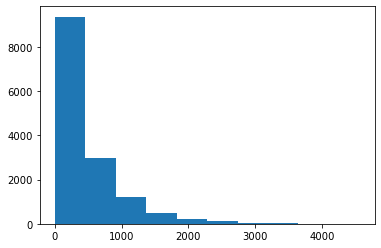

In [4]:
#distribution for ridership, all stations does not follow normal distribution
# plt.hist(data.groupby(['month','hour'])['ridership'].sum().values)
# plt.hist(data['ridership'],bins=100)

stationA=data[data['station_complex']=='116 St-Columbia University (1)']
plt.hist(stationA['ridership'])

Text(0.5, 1.0, 'Adjusting Predicted Ridership Using Sigmoid Fumction')

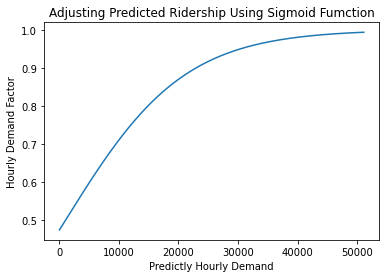

In [5]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

hourly_ridership=np.linspace(min(data['ridership']),
                            max(data['ridership']),
                            num=10000)


plt.plot(hourly_ridership,
        [sigmoid((i-1000)*0.0001) for i in hourly_ridership])
plt.xlabel("Predictly Hourly Demand")
plt.ylabel("Hourly Demand Factor")
plt.title("Adjusting Predicted Ridership Using Sigmoid Fumction")

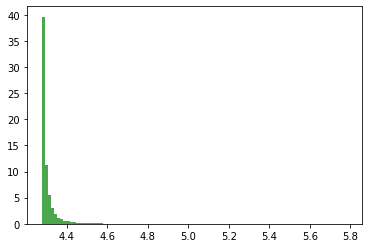

In [7]:
base_fare=2.9
fares=np.array([base_fare*(1+sigmoid((i-1000)*0.0001)) for i in data['ridership']])
count, bins, ignored =plt.hist(fares,bins=100,
         density=True,
         color='green',
         alpha=0.7,
        label="Histogram of Fares")

<BarContainer object of 100 artists>

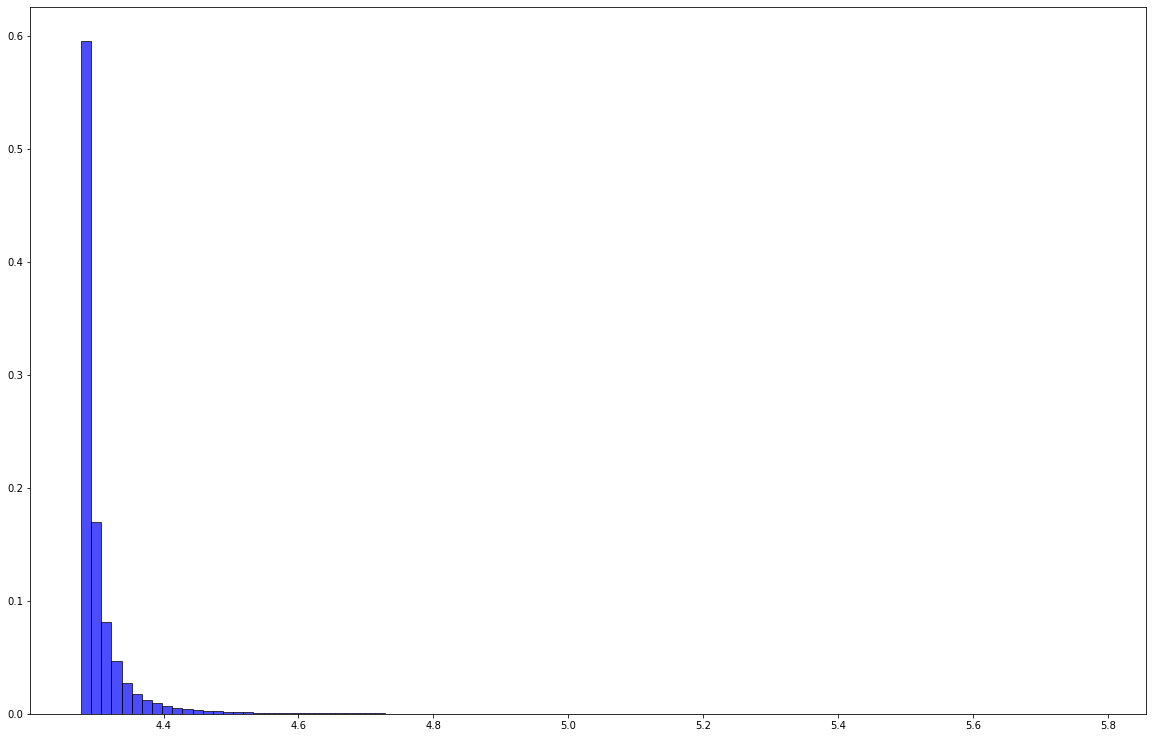

In [9]:
bin_width=bins[1]-bins[0]
plt.bar(bins[:-1],
        count/sum(count),
#         count/(len(fares)* bin_width),
        width=bin_width,
        alpha=0.7, color='blue', edgecolor='black',
        align='edge')

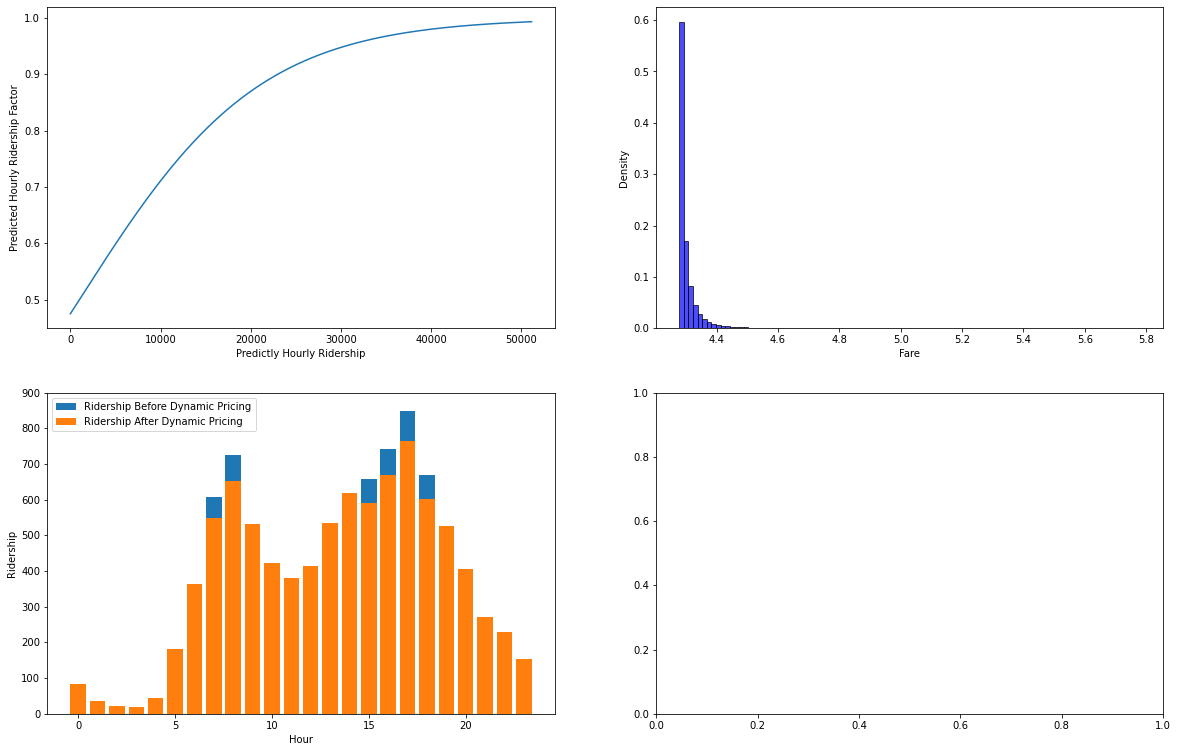

In [11]:
# sns.distplot(fares, kde=True)
fig, ax=plt.subplots(2,2)
plt.rcParams["figure.figsize"] = (20,13)
# plt.rcParams["figure.autolayout"] = True

ax[0,0].plot(hourly_ridership,
        [sigmoid((i-1000)*0.0001) for i in hourly_ridership])
ax[0,0].set_xlabel("Predictly Hourly Ridership")
ax[0,0].set_ylabel("Predicted Hourly Ridership Factor")
# ax[0,0].set_title("Adjust Predicted Ridership Using Sigmoid Fumction")
ax[0,1].bar(bins[:-1],
        count/sum(count),
        width=bin_width,
        alpha=0.7, color='blue', edgecolor='black',
        align='edge')
ax[0,1].set_xlabel('Fare')
ax[0,1].set_ylabel('Density')

ax[1,0].bar(avg_hrly_demand.hour,avg_hrly_demand.ridership_before,label="Ridership Before Dynamic Pricing")
ax[1,0].set_xlabel('Hour')
ax[1,0].set_ylim(bottom=0,top=900)
ax[1,0].set_ylabel('Ridership')

ax[1,0].bar(avg_hrly_demand.hour,avg_hrly_demand.ridership_after,label='Ridership After Dynamic Pricing')
ax[1,0].legend()
# fig.suptitle("Dynamic Pricing to Encourage People to Travel off Peak Hours")

In [37]:
fig=make_subplots(rows=2,cols=2,
                 subplot_titles=('Sigmoid on Predicted Riderhip',
                                 'Fare Distribution',
                                 'Effects of Dynamic Pricing'))
fig.add_trace(
    go.Scatter(x=hourly_ridership,
              y=[sigmoid((i-1000)*0.0001) for i in hourly_ridership],showlegend=False
              ),row=1,col=1
)
fig.update_xaxes(title_text="Predicted Hourly Ridership",row=1,col=1)
fig.update_yaxes(title_text="Predicted Hourly Ridership Factor",row=1,col=1)

fig.add_trace(go.Bar(x=bins[:-1],
                    y=count/sum(count),showlegend=False),
row=1,col=2)
fig.update_xaxes(title_text="Fare",row=1,col=2)
fig.update_yaxes(title_text="Density",row=1,col=2)


fig.add_trace(go.Bar(x=avg_hrly_demand.hour,y=avg_hrly_demand.ridership_before,
                     name="Before Dynamic Pricing",
                    ),row=2,col=1)
fig.add_trace(go.Bar(x=avg_hrly_demand.hour,y=avg_hrly_demand.ridership_after,
                     name="After Dynamic Pricing"
                    ),row=2,col=1)
fig.update_xaxes(title_text="Hour",row=2,col=1)
fig.update_yaxes(title_text="Ridership",row=2,col=1)
fig.update_layout(height=800, width=800,
                 legend=dict(x=0.5, y=-0.2, xanchor='center', yanchor='top'), # Adjust y to move legend inside subplot
    legend_orientation='h')
fig.show()


In [38]:
fig.write_html("visualizations/simulation/dynamic_pricing.html")

In [163]:
# fig.savefig("visualizations/simulation/dp.png")
def single_simulation(demand_shift_factor=0.1,diminishing_factor=0.98,base_fare=2,max_cap=2000,sig_steepness=0.0001,
                      event_factor=1,traffic_factor=1,cluster_factor=1):
    avg_hrly_demand=hourly_ridership_dataframe()
    
    early_peak_avg_demand=avg_hrly_demand[avg_hrly_demand['hour'].isin([7,8])]['ridership'].mean()
    aft_peak_avg_demand=avg_hrly_demand[avg_hrly_demand['hour'].isin([15,16,17,18])]['ridership'].mean()
    avg_hrly_demand.rename(columns={'ridership':'ridership_before'},inplace=True)

    avg_hrly_demand['ridership_after']=avg_hrly_demand['ridership_before']
    #assume dynamic pricing would encourage people to travel off rush hours, 1-2 hours early or late
    ridership_chg_morning=0
    for hr in [7,8]:
        ridership_chg_morning+=avg_hrly_demand.loc[hr,'ridership_before']*demand_shift_factor
        avg_hrly_demand.loc[hr,'ridership_after']=avg_hrly_demand.loc[hr,'ridership_before']*(1-demand_shift_factor)
    for hr in [6,9]:
        avg_hrly_demand.loc[hr,'ridership_after']=avg_hrly_demand.loc[hr,'ridership_before']+ridership_chg_morning/(2+2*diminishing_factor)
    for hr in [5,10]:
        avg_hrly_demand.loc[hr,'ridership_after']=avg_hrly_demand.loc[hr,'ridership_before']+ridership_chg_morning/(2+2*diminishing_factor)*diminishing_factor


    ridership_chg_aft=0
    for hr in [15,16,17,18]:
        ridership_chg_aft+=avg_hrly_demand.loc[hr,'ridership_before']*demand_shift_factor
        avg_hrly_demand.loc[hr,'ridership_after']=avg_hrly_demand.loc[hr,'ridership_before']*(1-demand_shift_factor)
    for hr in [14,19]:
        avg_hrly_demand.loc[hr,'ridership_after']=avg_hrly_demand.loc[hr,'ridership_before']+ridership_chg_aft/(2+2*diminishing_factor)
    for hr in [13,20]:
        avg_hrly_demand.loc[hr,'ridership_after']=avg_hrly_demand.loc[hr,'ridership_before']+ridership_chg_aft/(2+2*diminishing_factor)*diminishing_factor
    
    avg_hrly_demand['fare_before']=avg_hrly_demand['ridership_before'].apply(lambda i: base_fare*(1+sigmoid((i-max_cap/2)*sig_steepness*event_factor * traffic_factor * cluster_factor)))
    avg_hrly_demand['fare_after']=avg_hrly_demand['ridership_after'].apply(lambda i: base_fare*(1+sigmoid((i-max_cap/2)*sig_steepness*event_factor * traffic_factor * cluster_factor)))
    return sum(avg_hrly_demand['fare_before']*avg_hrly_demand['ridership_before'])*425*365,sum(avg_hrly_demand['fare_after']*avg_hrly_demand['ridership_after'])*425*365

In [164]:
def many_simulations(n=10,
                     demand_shift_factor=0.1,diminishing_factor=0.98,base_fare=2,max_cap=2000,sig_steepness=0.0001,
                      event_factor=1,traffic_factor=1,cluster_factor=1):
    revs_before=[]
    revs_after=[]
    for i in range(n):
        rev_before, rev_after=single_simulation(demand_shift_factor=0.1,diminishing_factor=0.98,base_fare=2,max_cap=2000,sig_steepness=0.0001,
                      event_factor=1,traffic_factor=1,cluster_factor=1)
        revs_before.append(rev_before)
        revs_after.append(rev_after)
    return np.mean(revs_before),np.mean(revs_after),np.std(revs_before),np.std(revs_after)

many_simulations()

(4185778058.467283, 4184222935.7289305, 1054930.136654641, 1053460.5472478434)

In [161]:
1013425465*3#annual total ridership

3040276395

In [168]:
# interact(many_simulations,
#         n=[10,50,100],
#          demand_shift_factor=FloatSlider(min=0.05,max=0.2,value=0.1,continuous_update=False)
#         )